<a href="https://colab.research.google.com/github/mizzmir/NLP/blob/machine_translation_develop/machine%20translation%20projects/Seq2SeqAttention/Seq2SeqAttentionColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow-gpu --quiet

In [2]:
!git clone https://github.com/mizzmir/data.git

fatal: destination path 'data' already exists and is not an empty directory.


In [0]:
import os
import re
import sys
import unicodedata
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def normalize(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?-]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def read_data(data_dir, file_name):
    full_path = os.path.join(data_dir, file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      lines = file.readlines()
    
    data = []

    for line in lines:
        data.append(line.split("\t")[:-1])
    
    return data

def read_data_files(data_dir, file_names):
    
    en_file_name, fr_file_name = file_names
    
    full_path = os.path.join(data_dir, en_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      en_lines = file.readlines()
    
    full_path = os.path.join(data_dir, fr_file_name)
    print("reading data from ", full_path)

    with open(full_path) as file:
      fr_lines = file.readlines()    
    
    return en_lines, fr_lines

In [5]:
data_dir = "/content/data"
en_lines, fr_lines = read_data_files(data_dir, ("small_vocab_en", "small_vocab_fr"))

#data = read_data(os.path.join(data_dir, "fra-eng"), "fra.txt")

#en_lines, fr_lines = list(zip(*data))
en_lines, fr_lines = shuffle(en_lines, fr_lines)

#en_lines = en_lines[:40000]
#fr_lines = fr_lines[:40000]

en_lines = [normalize(line) for line in en_lines]
fr_lines = [normalize(line) for line in fr_lines]

en_train, en_test, fr_train, fr_test = train_test_split(en_lines, fr_lines, shuffle=True, test_size=0.1)

en_lines = en_test
fr_lines = fr_test

# creating tokenizers
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en for en in en_train), target_vocab_size=2**13)

fr_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (fr for fr in fr_train), target_vocab_size=2**13)

print("en_tokenizer size ", en_tokenizer.vocab_size)
print("fr_tokenizer size ", fr_tokenizer.vocab_size)

en_tokenizer.save_to_file("en_tokenizer")
fr_tokenizer.save_to_file("fr_tokenizer")

# train dataset
fr_train_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_train]
fr_train_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_train]

fr_train_in = pad_sequences(fr_train_in, padding='post')
fr_train_out = pad_sequences(fr_train_out, padding='post')

# test dataset
fr_test_in = [[fr_tokenizer.vocab_size] + fr_tokenizer.encode(line) for line in fr_test]
fr_test_out = [fr_tokenizer.encode(line) + [fr_tokenizer.vocab_size+1] for line in fr_test]

fr_test_in = pad_sequences(fr_test_in, padding='post')
fr_test_out = pad_sequences(fr_test_out, padding='post')

en_train = [en_tokenizer.encode(line) for line in en_train]
en_test = [en_tokenizer.encode(line) for line in en_test]

en_train = pad_sequences(en_train, padding='post')
en_test = pad_sequences(en_test, padding='post')

reading data from  /content/data/small_vocab_en
reading data from  /content/data/small_vocab_fr
en_tokenizer size  542
fr_tokenizer size  710


In [0]:
#
# Encoder Decoder
#
"""
class that implements LuangAttention
  - uses current decoder output as input to calculate alligment vector
  - score = h_t_trans*W_a*h_s
  - h_t - decoder hideden_state
  - h_s - encoder_output
  - context_vector = softmax(score)
"""
class LuangAttention(tf.keras.Model):
  def __init__(self, lstm_size, attention_type):
    super(LuangAttention, self).__init__()

    self.W_a = tf.keras.layers.Dense(lstm_size, name="LuangAttention_W_a")
    self.W_a_tanh = tf.keras.layers.Dense(lstm_size, activation="tanh", name="LuangAttention_W_a_tanh")
    self.v_a = tf.keras.layers.Dense(1)
    self.type = attention_type
  
  def call(self, decoder_output, encoder_output):
    # encoder_output shape [batch_size, seq_max_len, hidden_units_of_encoder]
    # decoder_output shape [batch_size, 1, hidden_units of decoder]
    # score shape [batch_size, 1, seq_max_len]
    if self.type == "dot":
        score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
    elif self.type == "general":
        score = tf.matmul(decoder_output, self.W_a(encoder_output), transpose_b=True)
    elif self.type == "concat":
        decoder_output = tf.broadcast_to(decoder_output, encoder_output.shape)
        concated = self.W_a_tanh(tf.concat((decoder_output, encoder_output), axis=-1))
        score = tf.transpose(self.v_a(concated), [0,2,1])
    else:
        raise Exception("wrong score function selected")
        
    alignment_vector = tf.nn.softmax(score, axis=2)
    context_vector = tf.matmul(alignment_vector, encoder_output)

    return context_vector, alignment_vector

class Encoder(tf.keras.Model):
  def __init__(self, lstm_units, embedding_size, vocab_size):
    super(Encoder, self).__init__()

    self.units = lstm_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size, name="Encoder_embedding")
    self.lstm_layer = tf.keras.layers.LSTM(units=lstm_units, dropout=0.2, return_sequences=True, return_state=True, name="Encoder_LSTM")

  def call(self, input_seq, initial_state, training_mode):
    # input_seq =shape [batch_size, seq_max_len]
    # initial_state shape [batch_size, lstm_hidden_state_size]

    # embedding shape [batch_size, seq_max_len, embedding_size]
    embedded_input = self.embedding(input_seq, training=training_mode)
    #encoder output shape [batch_size, seq_max_len, lstm_size]
    # state_h, state_c shape 2*[batch_size, lstm_size]
    encoder_out, state_h, state_c = self.lstm_layer(inputs=embedded_input, initial_state=initial_state, training=training_mode)

    return encoder_out, state_h, state_c
  
  def init_states(self, batch_size):
    return (tf.zeros([batch_size, self.units]),
            tf.zeros([batch_size, self.units]))

class Decoder(tf.keras.Model):
  def __init__(self, lstm_units, embedding_size, vocab_size, attention_type):
    super(Decoder, self).__init__()

    self.units = lstm_units
    self.embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_size, name="Decoder_embedding")
    self.lstm_layer = tf.keras.layers.LSTM(lstm_units, dropout=0.2, return_sequences=True, return_state=True, name="Decoder_lstm")
    self.dense_layer = tf.keras.layers.Dense(vocab_size)
    self.attention = LuangAttention(lstm_units, attention_type)

    self.W_c = tf.keras.layers.Dense(lstm_units, activation="tanh", name="Attention_W_c")
    self.W_s = tf.keras.layers.Dense(vocab_size, name="Attenton_W_s")

  def call(self, decoder_input, hidden_states, encoder_output, training_mode):
    # decoder_input shape [batch_size, 1]
    # hidden_states shape 2*[batch_size, lstm_size]
    # encoder_output shape [batch_size, seq_max_len, lstm_size]
    embedded_input = self.embedding_layer(decoder_input, training=training_mode)
    # embedded_input shape [batch_size, 1, embedding_size]
    # lstm_out shape [batch_size, 1, lstm_size]
    # state_h, state_c shape 2*[batch_szie, lstm_size]
    lstm_out, state_h, state_c = self.lstm_layer(embedded_input, hidden_states, training=training_mode)

    # context shape [batch_size, 1 lstm_size]
    # alignment shape [batch_size, 1, source_len]
    context, alignment = self.attention(lstm_out, encoder_output)

    # lstm_out shape [batch_size, lstm_size + lstm_size]
    lstm_out = tf.concat([tf.squeeze(context, axis=1), tf.squeeze(lstm_out, axis=1)], axis=1, name="Decoder_concat")

    # output_vector shape [batch_size, lstm_units]
    output_vector = self.W_c(lstm_out)

    # conversion to vocabulary prob
    # output_vector shape [batch_size, vocab_size]
    output_vector = self.W_s(output_vector)
    return output_vector, state_h, state_c, alignment

In [0]:
def makeDatasets(train_data, test_data, batch_size, strategy=None):
        """
            Parameters:
                train_data - input data for training. Should be in form : en_train, fr_train_in, fr_train_out
                test_data - input data for test step. Should be in form : en_test, fr_test_in, fr_test_out
                batch_size - batch_size that should be used to create datasets
                strategy - strategy that datasets should use to be distributed across GPUs. Default is None
        """
        print("creating dataset...")
        en_train, fr_train_in, fr_train_out = train_data
        en_test, fr_test_in, fr_test_out = test_data
        
        train_dataset = tf.data.Dataset.from_tensor_slices((en_train, fr_train_in, fr_train_out))
        train_dataset = train_dataset.shuffle(len(en_train), reshuffle_each_iteration=True)\
                                         .batch(batch_size, drop_remainder=True)

        test_dataset = tf.data.Dataset.from_tensor_slices((en_test, fr_test_in, fr_test_out))
        test_dataset = test_dataset.shuffle(len(en_test), reshuffle_each_iteration=True)\
                                       .batch(batch_size, drop_remainder=True)
        
        if strategy is not None:
            train_dataset = strategy.experimental_distribute_dataset(train_dataset)
            test_dataset = strategy.experimental_distribute_dataset(test_dataset)
        
        return train_dataset, test_dataset

In [0]:
class Seq2SeqAttentionTrainer:
    def __init__(self, batch_size, lstm_size, embedding_size, tokenizers, predict_every):
        """
            Parameters: 
                batch_size - batch_size of input data,
                lstm_size - number of lstm units
                embedding_size - embedding size for wholde model    
                tokenizers - two tokenizers for input and output data. Should be in form en_tokenizer, fr_tokenizer
                predict_every - how often to write prediction during training
        """
        
        self.en_tokenizer, self.fr_tokenizer = tokenizers
        self.batch_size = batch_size
        self.lstm_size = lstm_size
        self.embedding_size = embedding_size
        self.predict_every = predict_every
        self.strategy = tf.distribute.MirroredStrategy()
        self.encoder = None
        self.decoder = None
        self.optimizer = None

    def translate(self, en_sentence):
        """
            Translates sentence
            
            Parameters:
                en_sentence - sentence that will be translated
            
            returns:
                translated sentence
                alingments matrix - attention matrix for given translation
        """
        tokenized_input_data = self.en_tokenizer.encode(en_sentence)      
        tokenized_input_data = tf.expand_dims(tokenized_input_data, 0)
        initial_states = self.encoder.init_states(1)
        encoder_out, state_h, state_c = self.encoder(tf.constant(tokenized_input_data), 
                                                     initial_states, 
                                                     training_mode=False)

        decoder_in = [self.fr_tokenizer.vocab_size]
        decoder_in = tf.expand_dims(decoder_in, 0)
        end_tag = self.fr_tokenizer.vocab_size+1
        output_seq = []
        alignments = []
        while True:
            decoder_out, state_h, state_c, alignment = self.decoder(decoder_in, 
                                                                    (state_h, state_c), 
                                                                    encoder_out, 
                                                                    training_mode=False)
            # argmax to get max index 
            decoder_in = tf.expand_dims(tf.argmax(decoder_out, -1), 0)
            predicted_data = decoder_in

            if  predicted_data.numpy()[0] == end_tag or len(output_seq) >=40:
                break
             
            alignments.append(alignment)
            output_seq.append(self.fr_tokenizer.decode(predicted_data.numpy()[0]))
            
        return "".join(output_seq), alignments

    def train(self, train_data, test_data, prediction_data, epochs, attention_type="general", restore_checkpoint=False):
        """
            Training method that uses distributed training
            
            Parameters:
                train_data - input data for training. Should be in form : en_train, fr_train_in, fr_train_out
                test_data - input data for test step. Should be in form : en_test, fr_test_in, fr_test_out
                prediction_data - input data for prediction step. Should be in form of: en_predict, fr_predict
                epochs - number of epochs that should be run
                attention_type - what attention method to use " dot/general/concat. Default - general
                restore_checkpoint - should we restore last checkpoint and resume training. Defualt set to false.
            
            retuns:
                tuple losses, accuracy where losses = (train_losses, test_losses), accuracy = (train-accuracy, test_accuracy)
        """
        
        print_heatmap=True
        
        en_predict, fr_predict = prediction_data
        en_vocab_size = self.en_tokenizer.vocab_size
        fr_vocab_size = self.fr_tokenizer.vocab_size + 2
        
        print ('Number of devices: {}'.format(self.strategy.num_replicas_in_sync))
        GLOBAL_BATCH_SIZE = self.batch_size*self.strategy.num_replicas_in_sync

        train_dataset_distr, test_dataset_distr = makeDatasets(train_data, test_data, GLOBAL_BATCH_SIZE, self.strategy)
        
        test_losses = []
        train_losses = []
        train_accuracyVec = []
        test_accuracyVec =[]
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

        prediction_idx = np.random.randint(low=0, high=len(en_predict), size=1)[0]
        prediction_en, prediction_fr = en_predict[prediction_idx], fr_predict[prediction_idx]
        print("prediction input : ", prediction_en)
        print("prediction output: ", prediction_fr)

        if not os.path.exists("heatmap"):
          os.mkdir("heatmap")

        alignments = []

        with self.strategy.scope():
            self.encoder = Encoder(lstm_units=self.lstm_size, 
                                   embedding_size=self.embedding_size, 
                                   vocab_size=en_vocab_size)
            
            self.decoder = Decoder(lstm_units=self.lstm_size, 
                                   embedding_size=self.embedding_size, 
                                   vocab_size=fr_vocab_size, 
                                   attention_type=attention_type)
            
            self.optimizer = tf.keras.optimizers.Adam(clipnorm=0.5)
            
            ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                       decoder = self.decoder,
                                       optimizer=self.optimizer,
                                       epoch=tf.Variable(1))

            manager = tf.train.CheckpointManager(ckpt, "./checkpoints/Seq2SeqAttention", max_to_keep=5)

            
            if manager.latest_checkpoint and restore_checkpoint:
                ckpt.restore(manager.latest_checkpoint)
                print ('Latest checkpoint restored!!')
            else:
                print("training from scratch")

            loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(
                        from_logits=True, reduction="none")
            
            def compute_loss(predictions, labels):
                mask = tf.math.logical_not(tf.math.equal(labels, 0))
                mask = tf.cast(mask, tf.int64)
                per_example_loss = loss_obj(labels, predictions, sample_weight=mask)
                return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)
            
            # one training step
            def train_step(en_data, fr_data_in, fr_data_out, initial_states):
                loss = 0
                predicted_output = None
                train_accuracy.reset_states()
                with tf.GradientTape() as tape:
                    encoder_output, state_h, state_c = self.encoder(en_data, 
                                                                    initial_states, 
                                                                    training_mode=True)
                    # shape[1] because we want each word for all batches
                    for i in range(fr_data_out.shape[1]):
                        decoder_input = tf.expand_dims(fr_data_in[:,i], 1)
                        decoder_output, state_h, state_c, _ = self.decoder(decoder_input,
                                                                           (state_h, state_c),
                                                                           encoder_output,
                                                                           training_mode=True)
                        
                        loss +=compute_loss(decoder_output, fr_data_out[:,i])
                        decoder_output = tf.expand_dims(decoder_output, axis=1)
                        if i == 0:
                          predicted_output = decoder_output
                        else:
                          predicted_output = tf.concat([predicted_output, decoder_output], axis=1)

                trainable_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
                grads = tape.gradient(loss, trainable_vars)
                self.optimizer.apply_gradients(zip(grads, trainable_vars))

                train_accuracy.update_state(fr_data_out, predicted_output)

                return loss / fr_data_out.shape[1]

            @tf.function
            def distributed_train_step(en_data, fr_data_in, fr_data_out, initial_states):
                per_replica_losses = self.strategy.experimental_run_v2(train_step,
                                                                  args=(en_data,
                                                                        fr_data_in,
                                                                        fr_data_out,
                                                                        initial_states,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

            def test_step(en_data, fr_data_in, fr_data_out):
                loss = 0
                predicted_output = []
                initial_states = self.encoder.init_states(self.batch_size)
                encoder_output, state_h, state_c = self.encoder(en_data, 
                                                                initial_states, 
                                                                training_mode=False)
                for i in range(fr_data_out.shape[1]):
                    decoder_input = tf.expand_dims(fr_data_in[:,i], 1)
                    decoder_output, state_h, state_c, _ = self.decoder(decoder_input,
                                                                    (state_h, state_c),
                                                                    encoder_output,
                                                                    training_mode=False)
                    loss +=compute_loss(decoder_output, fr_data_out[:,i])

                    decoder_output = tf.expand_dims(decoder_output, axis=1)
                    if i == 0:
                      predicted_output = decoder_output
                    else:
                      predicted_output = tf.concat([predicted_output, decoder_output], axis=1)
                      
                test_accuracy.update_state(fr_data_out, predicted_output)

                return loss/fr_data_out.shape[1]

            @tf.function
            def distributed_test_step(en_data, fr_data_in, fr_data_out):
                per_replica_losses = self.strategy.experimental_run_v2(test_step,
                                                                 args=(en_data,
                                                                       fr_data_in,
                                                                       fr_data_out,))
                return self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
            print("starting training with {} epochs with prediction each {} epoch" .format(epochs, self.predict_every))
            for epoch in range(epochs):
                test_accuracy.reset_states()
                train_accuracy.reset_states()
                initial_states = self.encoder.init_states(self.batch_size)
                
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(train_dataset_distr):
                    loss = distributed_train_step(en_data, fr_data_in, fr_data_out, initial_states)
                    total_loss += loss
                    num_batches += 1
                train_losses.append(total_loss/num_batches)
                total_loss = 0.0
                num_batches = 0
                for _, (en_data, fr_data_in, fr_data_out) in enumerate(test_dataset_distr):
                    loss = distributed_test_step(en_data, fr_data_in, fr_data_out)
                    total_loss += loss
                    num_batches += 1
                
                test_losses.append(total_loss/num_batches)
                print ('Epoch {} training Loss {:.4f} Accuracy {:.4f}  test Loss {:.4f} Accuracy {:.4f}' .format( \
                                                  epoch + 1, 
                                                  train_losses[-1], 
                                                  train_accuracy.result(),
                                                  test_losses[-1],
                                                  test_accuracy.result()))
                
                train_accuracyVec.append(train_accuracy.result())
                test_accuracyVec.append(test_accuracy.result())
                ckpt.epoch.assign_add(1)

                if int(epoch) % 5 == 0:
                    save_path = manager.save()
                    print("Saving checkpoint for epoch {}: {}".format(epoch, save_path))

                predicted, alignment  = self.translate(prediction_en)
                
                if epoch % self.predict_every == 0:
                    print("----------------------------PREDICTION----------------------------")
                    print("Predicted:  {} " .format(predicted))
                    print("Should be:  {} " .format(prediction_fr))
                    print("--------------------------END PREDICTION--------------------------")
                    
                if print_heatmap:
                    attention_map = np.squeeze(alignment, (1, 2))
                    alignments.append(attention_map)
                    fig = plt.figure(figsize=(10, 10))
                    ax = fig.add_subplot(1, 1, 1)
                    ax.matshow(attention_map, cmap='jet')
                    ax.set_xticklabels([''] + prediction_en.split(' '), rotation=90)
                    ax.set_yticklabels([''] + predicted.split(' '))

                    plt.savefig('heatmap/prediction_{}.png' .format(epoch))
                    #plt.show()
                    plt.close()
            save_path = manager.save()
            print ('Saving checkpoint for end at {}'.format(save_path))

        return (train_losses, test_losses), (train_accuracyVec, test_accuracyVec)

In [0]:
LSTM_SIZE = 512
EMBEDDING_SIZE = 250
BATCH_SIZE= 64
EPOCHS = 20

In [0]:
trainer = Seq2SeqAttentionTrainer(batch_size=BATCH_SIZE, 
                                  lstm_size=LSTM_SIZE, 
                                  embedding_size=EMBEDDING_SIZE, 
                                  tokenizers=[en_tokenizer, fr_tokenizer],
                                  predict_every=2)

In [11]:
losses, accuracy= trainer.train(train_data=[en_train, fr_train_in, fr_train_out], 
                                test_data=[en_test, fr_test_in, fr_test_out], 
                                prediction_data=[en_lines, fr_lines], 
                                epochs=EPOCHS, 
                                attention_type="concat")

Number of devices: 1
creating dataset...
prediction input :  he likes pears grapefruit and oranges . 
prediction output:  il aime les poires les pamplemousses et les oranges . 
training from scratch
starting training with 20 epochs with prediction each 2 epoch
Epoch 1 training Loss 0.4361 Accuracy 0.4732  test Loss 0.0678 Accuracy 0.6123
Saving checkpoint for epoch 0: ./checkpoints/Seq2SeqAttention/ckpt-1
----------------------------PREDICTION----------------------------
Predicted:  jersey est pluvieux pluvieux juin mais les fraise est son verts .  
Should be:  il aime les poires les pamplemousses et les oranges .  
--------------------------END PREDICTION--------------------------
Epoch 2 training Loss 0.0366 Accuracy 0.5975  test Loss 0.0242 Accuracy 0.6268
Epoch 3 training Loss 0.0203 Accuracy 0.6029  test Loss 0.0180 Accuracy 0.6292
----------------------------PREDICTION----------------------------
Predicted:  california est froid pendant juin et il est generalement pluvieux en oct

In [0]:
train_losses, test_losses = losses 
train_accuracyVec, test_accuracyVec = accuracy

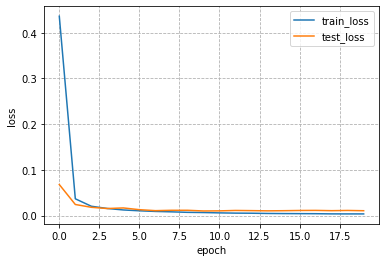

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_losses, label="train_loss")
fig_plot.plot(test_losses, label="test_loss")
fig_plot.legend(loc="upper right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("loss")
fig_plot.grid(linestyle="--")
fig.savefig("losses_plot.png")
fig.show()

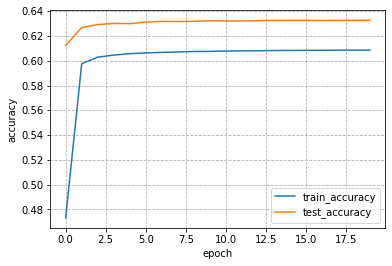

In [14]:
fig = plt.figure()
fig_plot = fig.add_subplot()
fig_plot.plot(train_accuracyVec, label="train_accuracy")
fig_plot.plot(test_accuracyVec, label="test_accuracy")
fig_plot.legend(loc="lower right")
fig_plot.set_xlabel("epoch")
fig_plot.set_ylabel("accuracy")
fig_plot.grid(linestyle="--")
fig.savefig("accuracy_plot.png")